In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

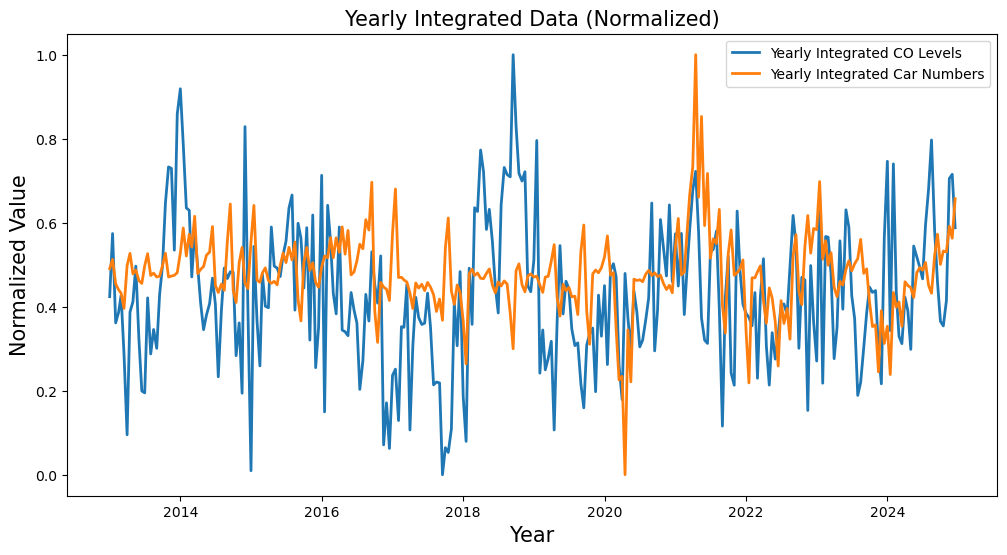

Correlation between yearly integrated datasets: 0.13
Maximum absolute correlation is at lag: -3.00 years
Correlation after shifting CO forward by 3.00 years: 0.05


<Figure size 1200x600 with 0 Axes>

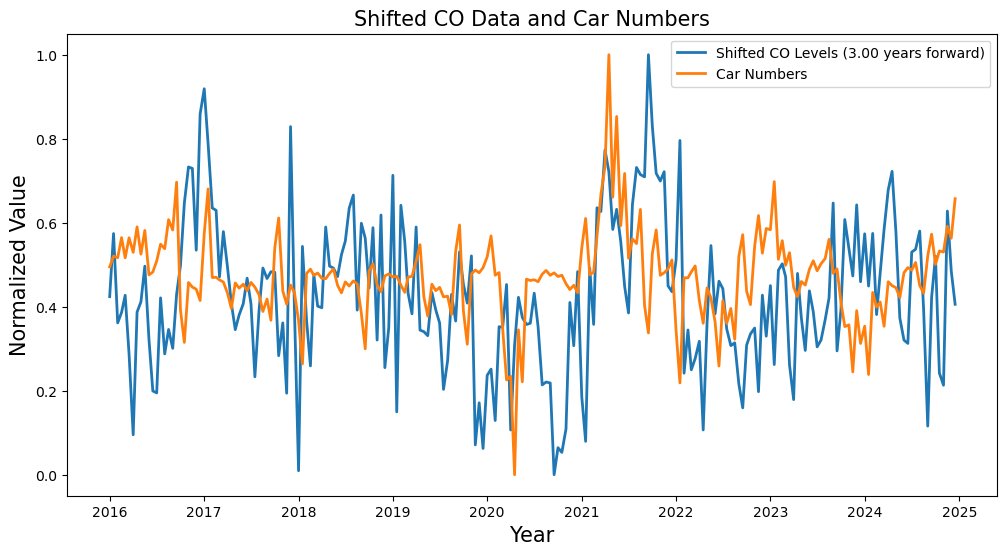

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.stattools import grangercausalitytests, coint
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# ---------------------
# 1. Load Data and Filter
# ---------------------
# Load the datasets
df_air = pd.read_csv('data/full_air_data_transformed.csv', parse_dates=['Date'])
df_cars = pd.read_csv('data/cars_transformed.csv', parse_dates=['Date'])

# Set the Date column as the index
df_air.set_index('Date', inplace=True)
df_cars.set_index('Date', inplace=True)

# Extract the relevant columns
dfCO = df_air[['CO']]
dfCars = df_cars[['car_num']]

# Filter data from 2012 to end of 2024
dfCO = dfCO[(dfCO.index >= '2012-01-01') & (dfCO.index <= '2024-12-31')]
dfCars = dfCars[(dfCars.index >= '2012-01-01') & (dfCars.index <= '2024-12-31')]

# ---------------------
# 2. Seasonal Decomposition
# ---------------------
# # Decompose the time series to extract the seasonal component
# decomposition_co = seasonal_decompose(dfCO, period=24, model='additive')
# decomposition_cars = seasonal_decompose(dfCars, period=24, model='additive')

# # Plot the decomposition results for CO
# decomposition_co.plot()
# plt.suptitle('Seasonal Decomposition of CO Levels', fontsize=15)
# plt.show()

# # Plot the decomposition results for Car Numbers
# decomposition_cars.plot()
# plt.suptitle('Seasonal Decomposition of Car Numbers', fontsize=15)
# plt.show()

# # ---------------------
# 3. Yearly Integration via Differencing
# ---------------------
# Assuming two samples per month, difference with period 24 to integrate seasonality by year
yearly_integration_co = dfCO.diff(periods=24).dropna()
yearly_integration_cars = dfCars.diff(periods=24).dropna()

# # Resample the integrated data to yearly frequency and sum the values
# yearly_integration_co = year_integration_co.resample('Y').sum()
# yearly_integration_cars = year_integration_cars.resample('Y').sum()

# Ensure both series have the same index
common_index = yearly_integration_co.index.intersection(yearly_integration_cars.index)
yearly_integration_co = yearly_integration_co.loc[common_index]
yearly_integration_cars = yearly_integration_cars.loc[common_index]

# ---------------------
# 4. Normalize the Data (Scaling to [0, 1])
# ---------------------
scaler = MinMaxScaler()
yearly_integration_co_scaled = scaler.fit_transform(yearly_integration_co)
yearly_integration_cars_scaled = scaler.fit_transform(yearly_integration_cars)

# ---------------------
# 5. Plot the Normalized Yearly Integrated Data
# ---------------------
plt.figure(figsize=(12, 6))
plt.plot(yearly_integration_co.index, yearly_integration_co_scaled, label='Yearly Integrated CO Levels', linewidth=2)
plt.plot(yearly_integration_cars.index, yearly_integration_cars_scaled, label='Yearly Integrated Car Numbers', linewidth=2)
plt.title("Yearly Integrated Data (Normalized)", fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Normalized Value', fontsize=15)
plt.legend()
plt.show()

# ---------------------
# 6. Correlation (Basic Correlation as a Starting Point)
# ---------------------
correlation = pd.Series(yearly_integration_co_scaled.flatten()).corr(
    pd.Series(yearly_integration_cars_scaled.flatten())
)
print(f"Correlation between yearly integrated datasets: {correlation:.2f}")



# ---------------------
# 7. Cross-Correlation Analysis
# ---------------------

# Cross-correlation function can help us identify if there is a lead/lag relationship.
plt.figure(figsize=(12, 6))
# Using the flattened series since our series are 1-D arrays
series_co = pd.Series(yearly_integration_co_scaled.flatten(), index=yearly_integration_co.index)
series_cars = pd.Series(yearly_integration_cars_scaled.flatten(), index=yearly_integration_cars.index)

# Calculate cross-correlation
cross_corr = np.correlate(series_co - series_co.mean(), series_cars - series_cars.mean(), mode='full')
lags = np.arange(-len(series_co) + 1, len(series_co))

# Find the lag with the maximum absolute correlation
max_abs_corr_lag_years = lags[np.argmax(np.abs(cross_corr))] // 24  # Convert to years
print(f"Maximum absolute correlation is at lag: {max_abs_corr_lag_years:.2f} years")

# Shift the CO series forward by the identified lag in years
shifted_co = series_co.shift(-max_abs_corr_lag_years * 24)  # Convert years back to periods for shift

# Align the shifted series with the car series
aligned_co = shifted_co.dropna()
aligned_cars = series_cars.loc[aligned_co.index]

# Calculate the correlation between the shifted CO series and the car series
shifted_correlation = aligned_co.corr(aligned_cars)
print(f"Correlation after shifting CO forward by {abs(max_abs_corr_lag_years):.2f} years: {shifted_correlation:.2f}")

# Plot the shifted data
plt.figure(figsize=(12, 6))
plt.plot(aligned_co.index, aligned_co, label=f'Shifted CO Levels ({abs(max_abs_corr_lag_years):.2f} years forward)', linewidth=2)
plt.plot(aligned_cars.index, aligned_cars, label='Car Numbers', linewidth=2)
plt.title("Shifted CO Data and Car Numbers", fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Normalized Value', fontsize=15)
plt.legend()
plt.show()



